# Assignment 3: Image Classification

**Assignment Responsible**: Natalie Lang.

Ido Levkovitch ID: 205619919

Ofir Itshak ID: 205796238

Hadas Sela ID:316312842

In this assignment, we will build a convolutional neural network that can predict 
whether two shoes are from the **same pair** or from two **different pairs**.
This kind of application can have real-world applications: for example to help
people who are visually impaired to have more independence.

We will explore two convolutional architectures. While we will give you starter
code to help make data processing a bit easier, in this assignment you have a chance to build your neural network all by yourself. 

You may modify the starter code as you see fit, including changing the signatures of
functions and adding/removing helper functions. However, please make sure that we can understand what you are doing and why.
 

In [50]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.utils import shuffle
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

## Question 1. Data (20%)

Download the data from https://www.dropbox.com/s/6gdcpmfddojrl8o/data.rar?dl=0.

Unzip the file. There are three
main folders: `train`, `test_w` and `test_m`. Data in `train` will be used for
training and validation, and the data in the other folders will be used for testing.
This is so that the entire class will have the same test sets. The dataset is comprised of triplets of pairs, where each such triplet of image pairs was taken in a similar setting (by the same person).

We've separated `test_w` and `test_m` so that we can track our model performance 
for women's shoes and men's shoes separately. Each of the test sets contain images of either exclusively men's shoes or women's
shoes.

Upload this data to Google Colab.
Then, mount Google Drive from your Google Colab notebook:

In [51]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


After you have done so, read this entire section 
before proceeding. There are right and wrong ways of
processing this data. If you don't make the correct choices, you may find
yourself needing to start over.
Many machine learning projects fail because of the lack of care taken during
the data processing stage.

### Part (a) -- 8%

Load the training and test data, and separate your training data into training and validation.
Create the numpy arrays `train_data`, `valid_data`, `test_w` and `test_m`, all of which should
be of shape `[*, 3, 2, 224, 224, 3]`. The dimensions of these numpy arrays are as follows:

- `*` - the number of triplets allocated to train, valid, or test
- `3` - the 3 pairs of shoe images in that triplet
- `2` - the left/right shoes
- `224` - the height of each image
- `224` - the width of each image
- `3` - the colour channels

So, the item `train_data[4,0,0,:,:,:]` should give us the left shoe of the first image of the fifth person.The item `train_data[4,0,1,:,:,:]`  should be the right shoe in the same pair. 
The item `train_data[4,1,1,:,:,:]`  should be the right shoe in a different pair of that same person.

When you first load the images using (for example) `plt.imread`, you may see a numpy array of shape
`[224, 224, 4]` instead of `[224, 224, 3]`. That last channel is what's called the alpha channel for transparent
pixels, and should be removed. 
The pixel intensities are stored as an integer between 0 and 255.
Make sure you normlize your images, namely, divide the intensities by 255 so that you have floating-point values between 0 and 1. Then, subtract 0.5
so that the elements of `train_data`, `valid_data` and `test_data` are between -0.5 and 0.5.
**Note that this step actually makes a huge difference in training!**

This function might take a while to run; it can takes several minutes to just
load the files from Google Drive.  If you want to avoid
running this code multiple times, you can save 
your numpy arrays and load it later:
https://docs.scipy.org/doc/numpy/reference/generated/numpy.save.html

In [52]:
# Set the random seed manually for reproducibility.
np.random.seed(1111)
torch.manual_seed(1111)

In [53]:
#data processing functions 
import glob

def remov_alpha_chanel(file):
  filename = file.split("/")[-1]   # get the name of the .jpg file
  img = plt.imread(file)           # read the image as a numpy array
  image= img[:, :, :3]/255 -0.5 # remove the alpha channel
  data_of_shoes = filename.split('_')
  if data_of_shoes[2]=='left':          #chack side (left/right)
     shoe_side = 0
  else:
    shoe_side = 1
  shoe = int(data_of_shoes[1])-1    # number pair shoe's person
  return filename,image,shoe,shoe_side
  


def create_shoes_np(path,numbers_of_persons):
   images={}
   data = np.zeros((numbers_of_persons,3,2,224,224,3),dtype=np.float64)
   for number_of_person,file in enumerate(sorted(glob.glob(path))):
     filename,image,shoe,shoe_side=remov_alpha_chanel(file)
     images[filename]=image
     data[int(number_of_person/6),shoe,shoe_side,:,:,:] = images[filename]
   return data
     





In [54]:
# Your code goes here. Make sure it does not get cut off
# You can use the code below to help you get started. You're welcome to modify
# the code or remove it entirely: it's just here so that you don't get stuck
# reading files



import glob


path = "/content/gdrive/My Drive/Intro_to_Deep_Learning/data/train/*" 
# images = remov_alpha_chanel(path)
shoes=create_shoes_np(path,113)


#Train and Validation partition.
reindex = np.random.permutation(len(shoes)) #shuffle
shoes= shoes[reindex]
train_data = shoes[:8*len(shoes)//10] #  include the first 90% of the elements in the shoes array.
valid_data= shoes[8*len(shoes)//10:]  #  include the last 10% of the elements in the shoes array.

#test_m
path = "/content/gdrive/My Drive/Intro_to_Deep_Learning/data/test_m/*" 
test_m=create_shoes_np(path,10)



#test_w
path = "/content/gdrive/My Drive/Intro_to_Deep_Learning/data/test_w/*" 
test_w=create_shoes_np(path,10)


In [ ]:
np.save('train_data.npy', train_data)
np.save('valid_data.npy', valid_data)
np.save('test_w.npy', test_w)
np.save('test_m.npy', test_m)

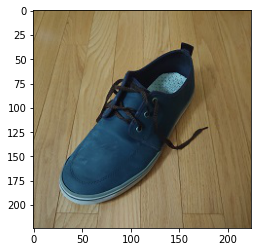

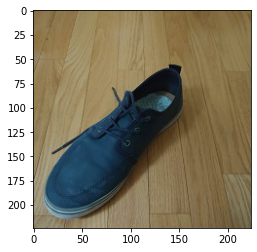

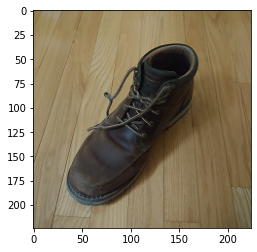

In [ ]:
# Run this code, include the image in your PDF submission
plt.figure()
plt.imshow(train_data[4,0,0,:,:,:]+0.5) # left shoe of first pair submitted by 5th student
plt.figure()
plt.imshow(train_data[4,0,1,:,:,:]+0.5) # right shoe of first pair submitted by 5th student
plt.figure()
plt.imshow(train_data[4,1,1,:,:,:]+0.5) # right shoe of second pair submitted by 5th student

### Part (b) -- 4%

Since we want to train a model that determines whether two shoes come from the **same**
pair or **different** pairs, we need to create some labelled training data.
Our model will take in an image, either consisting of two shoes from the **same pair**
or from **different pairs**. So, we'll need to generate some *positive examples* with
images containing two shoes that *are* from the same pair, and some *negative examples* where 
images containing two shoes that *are not* from the same pair.
We'll generate the *positive examples* in this part, and the *negative examples* in the next part.

Write a function `generate_same_pair()` that takes one of the data sets that you produced
in part (a), and generates a numpy array where each pair of shoes in the data set is
concatenated together. In particular, we'll be concatenating together images of left
and right shoes along the **height** axis. Your function `generate_same_pair` should
return a  numpy array of shape `[*, 448, 224, 3]`.

While at this stage we are working with numpy arrays, later on, we will need to convert this numpy array into a PyTorch tensor with shape
`[*, 3, 448, 224]`. For now, we'll keep the RGB channel as the last dimension since
that's what `plt.imshow` requires.

(90, 3, 2, 224, 224, 3)
(270, 448, 224, 3)


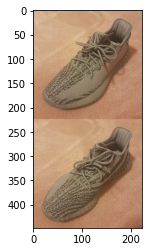

In [ ]:
# Your code goes here

# Run this code, include the result with your PDF submission
def generate_same_pair(data):
    same_pair=np.empty((3*len(data),448, 224, 3))
    for i in range(len(data)): # i shoe.
        for j in range(3): # j-pair.
            same_pair[j+3*i]=np.concatenate((data[i,j,0],data[i,j,1]),axis=0)
    return same_pair


print(train_data.shape) # if this is [N, 3, 2, 224, 224, 3]
print(generate_same_pair(train_data).shape) # should be [N*3, 448, 224, 3]
plt.imshow(generate_same_pair(train_data)[0]+0.5) # should show 2 shoes from the same pair

### Part (c) -- 4%

Write a function `generate_different_pair()` that takes one of the data sets that
you produced in part (a), and generates a numpy array in the same shape as part (b).
However, each image will contain 2 shoes from a **different** pair, but submitted
by the **same student**. Do this by jumbling the 3 pairs of shoes submitted by 
each student.

Theoretically, for each person (triplet of pairs), there are 6 different combinations
of "wrong pairs" that we could produce. To keep our data set *balanced*, we will
only produce **three** combinations of wrong pairs per unique person.
In other words,`generate_same_pairs` and `generate_different_pairs` should
return the same number of training examples.

(90, 3, 2, 224, 224, 3)
(270, 448, 224, 3)


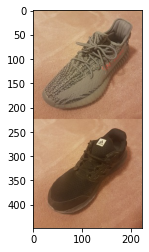

In [ ]:
# Your code goes here

      
def generate_different_pair(data):
  diff_pair = np.empty((len(data)*3,448, 224,3))
  for i in range(np.shape(data)[0]):
    for j in range(3):
      diff_pair[3*i + j, :224,:,:] = data[i,(j-1)%3,0,:,:,:]
      diff_pair[3*i + j, 224:,:,:] = data[i,j,1,:,:,:]

  return diff_pair



# Run this code, include the result with your PDF submission
print(train_data.shape) # if this is [N, 3, 2, 224, 224, 3]
print(generate_different_pair(train_data).shape) # should be [N*3, 448, 224, 3]
plt.imshow(generate_different_pair(train_data)[1]+0.5) # should show 2 shoes from different pairs

### Part (d) -- 2%

Why do we insist that the different pairs of shoes still come from the same
person?  (Hint: what else do images from the same person have in common?)

**Write your explanation here:**
Images that come from the same person also have the same background.
We seek that since this is the case where we actually train our model to focus on the shoe rather than its background.
If that wasn't the case, then it would probably be much easier do differentiate shoes simply since they would have had different backgrounds, and unnecessarily since they have different shoes.

### Part (e) -- 2%

Why is it important that our data set be *balanced*? In other words suppose we created
a data set where 99% of the images are of shoes that are *not* from the same pair, and 
1% of the images are shoes that *are* from the same pair. Why could this be a problem?

**Write your explanation here:**
Our model needs to learn to decide if shoes are the same pair as much as it needs to learn to decide if they are not. If we would have supplied imbalanced data of more shoes that are not from the same pair, we would have "encouraged" our model to almost always decide that the shoes are not from the same pair. 
If we supply 99% shoes not from same pair and 1% of same pair, a model trained on this dataset might achieve a high accuracy by simply predicting "not from same pair" for every input. However, this model would not generalize well to a dataset with a more balanced distribution of classes, and it would not be able to accurately classify shoes that do come from the same pair.

## Question 2. Convolutional Neural Networks (25%)

Before starting this question, we recommend reviewing the lecture and its associated example notebook on CNNs.

In this section, we will build two CNN models in PyTorch.

### Part (a) -- 9%

Implement a CNN model in PyTorch called `CNN` that will take images of size
$3 \times 448 \times 224$, and classify whether the images contain shoes from
the same pair or from different pairs.

The model should contain the following layers:

- A convolution layer that takes in 3 channels, and outputs $n$ channels.
- A $2 \times 2$ downsampling (either using a strided convolution in the previous step, or max pooling)
- A second convolution layer that takes in $n$ channels, and outputs $2\cdot n$ channels.
- A $2 \times 2$ downsampling (either using a strided convolution in the previous step, or max pooling)
- A third convolution layer that takes in $2\cdot n$ channels, and outputs $4\cdot n$ channels.
- A $2 \times 2$ downsampling (either using a strided convolution in the previous step, or max pooling)
- A fourth convolution layer that takes in $4\cdot n$ channels, and outputs $8\cdot n$ channels.
- A $2 \times 2$ downsampling (either using a strided convolution in the previous step, or max pooling)
- A fully-connected layer with 100 hidden units
- A fully-connected layer with 2 hidden units

Make the variable $n$ a parameter of your CNN. You can use either $3 \times 3$ or $5 \times 5$
convolutions kernels. Set your padding to be `(kernel_size - 1) / 2` so that your feature maps
have an even height/width.

Note that we are omitting in our description certain steps that practitioners will typically not mention,
like ReLU activations and reshaping operations. Use the example presented in class to figure out where they are.

In [ ]:
class CNN(nn.Module):
  def __init__(self, n, kernel_size=5):
    super(CNN, self).__init__()
    self.n = n
    self.conv1 = nn.Conv2d(3, n, kernel_size, padding=(kernel_size - 1) // 2)
    self.conv2 = nn.Conv2d(n, 2 * n, kernel_size, padding=(kernel_size - 1) // 2)
    self.conv3 = nn.Conv2d(2 * n, 4 * n, kernel_size, padding=(kernel_size - 1) // 2)
    self.conv4 = nn.Conv2d(4 * n, 8 * n, kernel_size, padding=(kernel_size - 1) // 2)
    self.fc1 = nn.Linear(8 * n *28*14, 100)
    self.fc2 = nn.Linear(100, 2)

  def forward(self, x):
    x = F.max_pool2d(F.relu(self.conv1(x)), 2)
    x = F.max_pool2d(F.relu(self.conv2(x)), 2)
    x = F.max_pool2d(F.relu(self.conv3(x)), 2)
    x = F.max_pool2d(F.relu(self.conv4(x)), 2)
    x = x.reshape(-1, 8 * self.n *28*14)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x




### Part (b) -- 8%

Implement a CNN model in PyTorch called `CNNChannel` that contains the same layers as
in the Part (a), but with one crucial difference: instead of starting with an image
of shape $3 \times 448 \times 224$, we will first manipulate the image so that the
left and right shoes images are concatenated along the **channel** dimension.

<img src="https://drive.google.com/uc?id=1B59VE43X-6Dw3ag-9Ndn6vPEzbnFem8K" width="400px" />


Complete the manipulation in the `forward()` method (by slicing and using
the function `torch.cat`). The input to the first convolutional layer
should have 6 channels instead of 3 (input shape $6 \times 224 \times 224$).

Use the same hyperparameter choices as you did in part (a), e.g. for the kernel size,
choice of downsampling, and other choices.

In [ ]:
class CNNChannel(nn.Module):
  def __init__(self, n, kernel_size=5):
    super(CNNChannel, self).__init__()
    self.n = n
    pad = int((kernel_size-1)//2)
    stride_size = 1
    self.conv1 = nn.Conv2d(6, n, kernel_size, padding=pad)
    self.conv2 = nn.Conv2d(n, 2 * n, kernel_size, padding=pad)
    self.conv3 = nn.Conv2d(2 * n, 4 * n, kernel_size, padding=pad)
    self.conv4 = nn.Conv2d(4 * n, 8 * n, kernel_size, padding=pad)

    self.fc1 = nn.Linear(8 * n * 14 * 14, 100)
    self.fc2 = nn.Linear(100, 2)

  def forward(self, x):
  # Concatenate the left and right shoe images along the channel dimension
   x=x.float()
   if x.size()[3] != 224:
     x = x.transpose(2,3)
   x = torch.cat((x[:,:,:224,:],x[:,:,224:,:]),dim = 1)
  #  x = torch.cat((x[:, 0], x[:, 1]), dim=1)
   x = F.max_pool2d(F.relu(self.conv1(x)), 2)
   x = F.max_pool2d(F.relu(self.conv2(x)), 2)
   x = F.max_pool2d(F.relu(self.conv3(x)), 2)
   x = F.max_pool2d(F.relu(self.conv4(x)), 2)
   x = x.reshape(-1, 8 * self.n * 14 * 14)
   x = F.relu(self.fc1(x))
   x = self.fc2(x)
   return x



## Part (c) -- 4%

The two models are quite similar, and should have almost the same number of parameters.
However, one of these models will perform better, showing that architecture choices **do**
matter in machine learning. Explain why one of these models performs better.

**Write your explanation here:**

The first method is learning each pair independantly as they appear "alongside" and therefore emphasizes outlines and shape resemblance, while the second method is learning each pair one on top of the other, and therefore emphasizes differene and is expected to perform better.That is since we seek to identify difference of pairs rather than doing it via indentifying their shape first. and then checking if and how much different they are with it.

## Part (d) -- 4%

The function `get_accuracy` is written for you. You may need to modify this
function depending on how you set up your model and training.

Unlike in the previous assignment, her we will separately compute the model accuracy on the
positive and negative samples.  Explain why we may wish to track the false positives and false negatives separately.

**Write your explanation here:**
As we generate the images of 2 shoes that do not belong to the same pair, we have control of its relative size and can adjust it for improvements.
We want to make sure our model is not biased towards calssifying one of the predictions.

In [ ]:
def get_accuracy(model, data, batch_size=50):
    """Compute the model accuracy on the data set. This function returns two
    separate values: the model accuracy on the positive samples,
    and the model accuracy on the negative samples.

    Example Usage:

    >>> model = CNN() # create untrained model
    >>> pos_acc, neg_acc= get_accuracy(model, valid_data)
    >>> false_positive = 1 - pos_acc
    >>> false_negative = 1 - neg_acc
    """

    model.eval()
    n = data.shape[0]

    data_pos = generate_same_pair(data)      # should have shape [n * 3, 448, 224, 3]
    data_neg = generate_different_pair(data) # should have shape [n * 3, 448, 224, 3]

    pos_correct = 0
    for i in range(0, len(data_pos), batch_size):
        xs = torch.Tensor(data_pos[i:i+batch_size]).transpose(1, 3)
        xs =xs.transpose(2,3)
        zs = model(xs)
        pred = zs.max(1, keepdim=True)[1] # get the index of the max logit
        pred = pred.detach().numpy()
        pos_correct += (pred == 1).sum()
    
    neg_correct = 0
    for i in range(0, len(data_neg), batch_size):
        xs = torch.Tensor(data_neg[i:i+batch_size]).transpose(1, 3)
        xs =xs.transpose(2,3)
        zs = model(xs)
        pred = zs.max(1, keepdim=True)[1] # get the index of the max logit
        pred = pred.detach().numpy()
        neg_correct += (pred == 0).sum()

    return pos_correct / (n * 3), neg_correct / (n * 3)

## Question 3. Training (40%)

Now, we will write the functions required to train the model. 

Although our task is a binary classification problem, we will still use the architecture
of a multi-class classification problem. That is, we'll use a one-hot vector to represent
our target (like we did in the previous assignment). We'll also use `CrossEntropyLoss` instead of
`BCEWithLogitsLoss` (this is a standard practice in machine learning because
this architecture often performs better).

### Part (a) -- 22%

Write the function `train_model` that takes in (as parameters) the model, training data,
validation data, and other hyperparameters like the batch size, weight decay, etc.
This function should be somewhat similar to the training code that you wrote
in Assignment 2, but with a major difference in the way we treat our training data.

Since our positive (shoes of the same pair) and negative (shoes of different pairs) training sets are separate, it is actually easier for
us to generate separate minibatches of positive and negative training data.
 In
each iteration, we'll take `batch_size / 2` positive samples and `batch_size / 2`
negative samples. We will also generate labels of 1's for the positive samples,
and 0's for the negative samples.

Here is what your training function should include:

- main training loop; choice of loss function; choice of optimizer
- obtaining the positive and negative samples
- shuffling the positive and negative samples at the start of each epoch
- in each iteration, take `batch_size / 2` positive samples and `batch_size / 2` negative samples
  as our input for this batch
- in each iteration, take `np.ones(batch_size / 2)` as the labels for the positive samples, and 
  `np.zeros(batch_size / 2)` as the labels for the negative samples
- conversion from numpy arrays to PyTorch tensors, making sure that the input has dimensions $N \times C \times H \times W$ (known as NCHW tensor), where $N$ is the number of images batch size, $C$ is the number of channels, $H$ is the height of the image, and $W$ is the width of the image. 
- computing the forward and backward passes 
- after every epoch, report the accuracies for the training set and validation set
- track the training curve information and plot the training curve

It is also recommended to checkpoint your model (save a copy) after every epoch, as we did in Assignment 2.

In [ ]:
# Write your code here
def data_shuffle(data, label):
  reindex = np.random.permutation(len(data)) #shuffle
  data = data[reindex]
  label = label[reindex]
  return data, label

In [ ]:
def train_model(model, train_data, valid_data, weight_decay=0, learning_rate=1e-3, batch_size=50, num_epochs=10,print_number=10,save_model=False):

  iters, losses = [], []
  iters_sub, train_pos_accs, train_neg_accs, val_pos_accs, val_neg_accs  = [], [] ,[] , [] , []   
  best_accuracy=0
# Create the loss function and optimizer
  loss_fn = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), weight_decay=weight_decay, lr=learning_rate)

  # Training loop
  training_curve = []
  for epoch in range(num_epochs):
      model.train()
    
    # Shuffle the training data
      reindex = np.random.permutation(len(train_data))
      train_data = train_data[reindex]
      positive_data = generate_same_pair(train_data)
      negative_data = generate_different_pair(train_data)
      # reindex = np.random.permutation(len(positive_data))
      # positive_data = positive_data[reindex]
      # reindex = np.random.permutation(len(negative_data))
      # negative_data = negative_data[reindex]
    
    # Loop through the training data in batches
      for i in range(0, len(train_data), batch_size):
          pos_xs = torch.Tensor(positive_data[i:i+batch_size//2]).transpose(1,3)
          pos_xs =pos_xs.transpose(2,3)
          neg_xs = torch.Tensor(negative_data[i:i+batch_size//2]).transpose(1,3)
          neg_xs =neg_xs.transpose(2,3)
          xs=torch.cat((pos_xs, neg_xs), axis=0)
          pos_labels = np.ones(batch_size // 2)
          neg_labels = np.zeros(batch_size // 2)
          ys =np.concatenate((pos_labels, neg_labels), axis=0)
          #print( train_data[i:i+batch_size].shape)
         # xs_diff = torch.Tensor(generate_different_pair(train_data[i:i+batch_size])).transpose(1, 3)
        
          optimizer.zero_grad()
          zs = model(xs)
          loss = loss_fn(zs, torch.Tensor(ys).long())
          # loss = F.nll_loss(zs, torch.Tensor(ys).long())
          loss.backward()
          optimizer.step()

          iters.append(epoch)
          losses.append(float(loss)/batch_size)
    
    # Print the accuracy on the training set
      if  epoch % print_number == 0:
        iters_sub.append(epoch)
        pos_acc, neg_acc = get_accuracy(model, train_data, batch_size=batch_size)
        train_pos_accs.append(pos_acc)
        train_neg_accs.append(neg_acc)
        print(f"Epoch {epoch}: Training accuracy pos = {pos_acc} ,  Training accuracy neg ={neg_acc}, Training accuracy = {(pos_acc + neg_acc) / 2} ")
        training_curve.append((pos_acc + neg_acc) / 2)
      
      # Print the accuracy on the validation set
        pos_acc, neg_acc = get_accuracy(model, valid_data, batch_size=batch_size)
        print(f"Epoch {epoch}: Validation accuracy pos = {pos_acc} ,  Validation accuracy neg ={neg_acc}, Validation accuracy = {(pos_acc + neg_acc) / 2} ")
        val_pos_accs.append(pos_acc)
        val_neg_accs.append(neg_acc)
        accs=(pos_acc + neg_acc) / 2
        if save_model:
          if accs>best_accuracy:
            best_accuracy=accs
            best_model=model
  if save_model:
   return iters, losses, iters_sub, train_pos_accs,train_neg_accs, val_pos_accs, val_neg_accs,best_model
  else:
    return iters, losses, iters_sub, train_pos_accs,train_neg_accs, val_pos_accs, val_neg_accs





In [ ]:

def plot_learning_curve(iters, losses, iters_sub, train_accs_pos,train_accs_neg, val_accs_pos,val_accs_neg):
    """
    Plot the learning curve.
    """
    plt.title("Learning Curve: Loss per Iteration")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Learning Curve: Positive Accuracy per Iteration")
    plt.plot(iters_sub, train_accs_pos, label="Train")
    plt.plot(iters_sub, val_accs_pos, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

    plt.title("Learning Curve: Negative Accuracy per Iteration")
    plt.plot(iters_sub, train_accs_neg, label="Train")
    plt.plot(iters_sub, val_accs_neg, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

### Part (b) -- 6%

Sanity check your code from Q3(a) and from Q2(a) and Q2(b) by showing that your models
can memorize a very small subset of the training set (e.g. 5 images).
You should be able to achieve 90%+ accuracy (don't forget to calculate the accuracy)
relatively quickly (within ~30 or so iterations).


(Start with the second network, it is easier to converge)

Try to find the general parameters combination that work for each network, it can help you a little bit later.

Epoch 0: Training accuracy pos = 1.0 ,  Training accuracy neg =0.0, Training accuracy = 0.5 
Epoch 0: Validation accuracy pos = 1.0 ,  Validation accuracy neg =0.0, Validation accuracy = 0.5 
Epoch 10: Training accuracy pos = 0.5333333333333333 ,  Training accuracy neg =0.7333333333333333, Training accuracy = 0.6333333333333333 
Epoch 10: Validation accuracy pos = 0.8 ,  Validation accuracy neg =0.3333333333333333, Validation accuracy = 0.5666666666666667 
Epoch 20: Training accuracy pos = 0.7333333333333333 ,  Training accuracy neg =0.7333333333333333, Training accuracy = 0.7333333333333333 
Epoch 20: Validation accuracy pos = 0.5333333333333333 ,  Validation accuracy neg =0.9333333333333333, Validation accuracy = 0.7333333333333334 
Training accuracy = 0.9


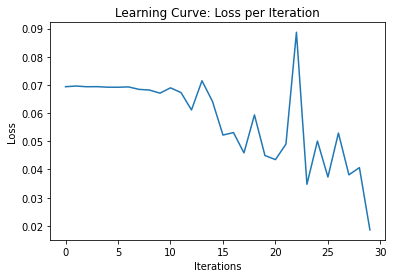

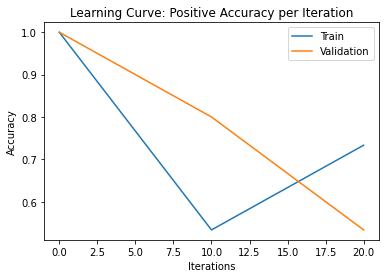

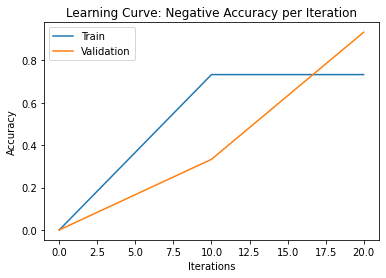

In [66]:
# # Write your code here. Remember to include your results so that we can
# # see that your model attains a high training accuracy. 

# Q.2(b)
model = CNNChannel(8)
train_data_small = train_data[:5]
valid_data_small = valid_data[:5]

# Train the model on the small subset of the data
iters, losses, iters_sub, train_pos_accs,train_neg_accs, val_pos_accs, val_neg_accs=train_model(model, train_data_small, valid_data_small, learning_rate=0.001,batch_size=10, num_epochs=30)


# Calculate the accuracy on the small subset of the data
pos_acc, neg_acc = get_accuracy(model, train_data_small, batch_size=5)
print(f"Training accuracy = {(pos_acc + neg_acc) / 2}")

plot_learning_curve(iters, losses, iters_sub, train_pos_accs,train_neg_accs, val_pos_accs, val_neg_accs)


Epoch 0: Training accuracy pos = 0.0 ,  Training accuracy neg =1.0, Training accuracy = 0.5 
Epoch 0: Validation accuracy pos = 0.0 ,  Validation accuracy neg =1.0, Validation accuracy = 0.5 
Epoch 10: Training accuracy pos = 1.0 ,  Training accuracy neg =0.0, Training accuracy = 0.5 
Epoch 10: Validation accuracy pos = 1.0 ,  Validation accuracy neg =0.0, Validation accuracy = 0.5 
Epoch 20: Training accuracy pos = 0.13333333333333333 ,  Training accuracy neg =0.8666666666666667, Training accuracy = 0.5 
Epoch 20: Validation accuracy pos = 0.0 ,  Validation accuracy neg =1.0, Validation accuracy = 0.5 
Epoch 30: Training accuracy pos = 0.2 ,  Training accuracy neg =0.8, Training accuracy = 0.5 
Epoch 30: Validation accuracy pos = 0.0 ,  Validation accuracy neg =0.9333333333333333, Validation accuracy = 0.4666666666666667 
Epoch 40: Training accuracy pos = 0.26666666666666666 ,  Training accuracy neg =0.6, Training accuracy = 0.43333333333333335 
Epoch 40: Validation accuracy pos = 0.0

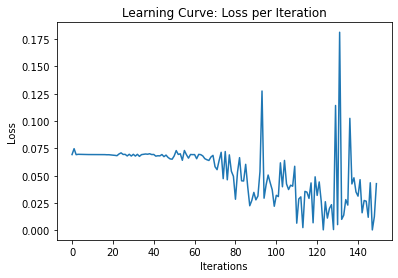

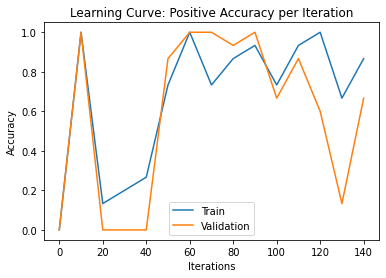

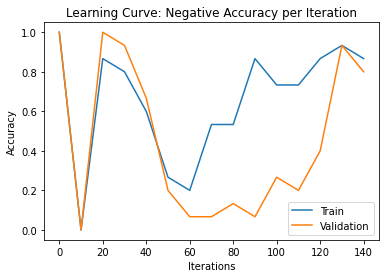

In [ ]:

# Q.2(a)
model =  CNN(8)
train_data_small = train_data[:5]
valid_data_small = valid_data[:5]

# Train the model on the small subset of the data
iters, losses, iters_sub, train_pos_accs,train_neg_accs, val_pos_accs, val_neg_accs=train_model(model, train_data_small, valid_data_small, learning_rate=0.001,batch_size=10, num_epochs=150)

# Calculate the accuracy on the small subset of the data
pos_acc, neg_acc = get_accuracy(model, train_data_small, batch_size=10)
print(f"Training accuracy = {(pos_acc + neg_acc) / 2}")

plot_learning_curve(iters, losses, iters_sub, train_pos_accs,train_neg_accs, val_pos_accs, val_neg_accs)


### Part (c) -- 8%

Train your models from Q2(a) and Q2(b). Change the values of a few 
hyperparameters, including the learning rate, batch size, choice of $n$, and 
the kernel size. You do not need to check all values for all hyperparameters. Instead, try to make big changes to see how each change affect your scores.
(try to start with finding a resonable learning rate for each network, that start changing the other parameters, the first network might need bigger $n$ and kernel size)

In this section, explain how you tuned your hyperparameters.

**Write your explanation here:** At first we find the best learning rate that give as the highest accuracy on the train. after finding the best learning rate , we run on two loop that find as the best n and kernel size. at last we find the best batch size.

In [ ]:
# Include the training curves for the two models.
# Q.2(b) model CNNChannel
learning_rate = [0.0001,0.001,0.005,0.01,0.5]
best_accuracy=0
best_learning_rate=0
for lr in learning_rate:
    print(f'current learning rate is - {lr}')
    CNNChannel_model = CNNChannel(n=8)
    train_model(CNNChannel_model, train_data, valid_data, learning_rate=lr,batch_size=10, num_epochs=100,print_number=10)
    pos_acc, neg_acc = get_accuracy(CNNChannel_model, train_data, batch_size=100)
    accuracy=(pos_acc + neg_acc) / 2
    if  accuracy>best_accuracy:
      best_accuracy=accuracy
      best_learning_rate=lr

print(f'the best learning rate is - {best_learning_rate} with train accuracy -  {best_accuracy}')




current learning rate is - 0.0001
Epoch 0: Training accuracy pos = 0.0 ,  Training accuracy neg =1.0, Training accuracy = 0.5 
Epoch 0: Validation accuracy pos = 0.0 ,  Validation accuracy neg =1.0, Validation accuracy = 0.5 
Epoch 10: Training accuracy pos = 0.8851851851851852 ,  Training accuracy neg =0.7185185185185186, Training accuracy = 0.8018518518518518 
Epoch 10: Validation accuracy pos = 0.8695652173913043 ,  Validation accuracy neg =0.7971014492753623, Validation accuracy = 0.8333333333333333 
Epoch 20: Training accuracy pos = 0.9037037037037037 ,  Training accuracy neg =0.7407407407407407, Training accuracy = 0.8222222222222222 
Epoch 20: Validation accuracy pos = 0.9130434782608695 ,  Validation accuracy neg =0.8260869565217391, Validation accuracy = 0.8695652173913043 
Epoch 30: Training accuracy pos = 0.9407407407407408 ,  Training accuracy neg =0.7481481481481481, Training accuracy = 0.8444444444444444 
Epoch 30: Validation accuracy pos = 0.9130434782608695 ,  Validatio

In [ ]:
n_channels = [4,8,16,24]
kernel_size=[3,5]
best_accuracy=0
for n in n_channels:
  for k in kernel_size:
    print(f'current channel - {n} , current kernel size - {k} ')
    CNNChannel_model = CNNChannel(n,k)
    train_model(CNNChannel_model, train_data, valid_data, learning_rate=best_learning_rate,batch_size=10, num_epochs=30,print_number=10)
    pos_acc, neg_acc = get_accuracy(CNNChannel_model, train_data, batch_size=10)
    accuracy=(pos_acc + neg_acc) / 2
    if  accuracy>best_accuracy:
      best_accuracy=accuracy
      best_n_channels=n
      best_kernel_size=k

print(f'the best n channels is - {best_n_channels} and the best kernel size  is - {best_kernel_size} with train accuracy -  {best_accuracy}')



current channel - 4 , current kernel size - 3 
Epoch 0: Training accuracy pos = 1.0 ,  Training accuracy neg =0.0, Training accuracy = 0.5 
Epoch 0: Validation accuracy pos = 1.0 ,  Validation accuracy neg =0.0, Validation accuracy = 0.5 
Epoch 10: Training accuracy pos = 0.5407407407407407 ,  Training accuracy neg =0.8111111111111111, Training accuracy = 0.6759259259259259 
Epoch 10: Validation accuracy pos = 0.5507246376811594 ,  Validation accuracy neg =0.8840579710144928, Validation accuracy = 0.7173913043478262 
Epoch 20: Training accuracy pos = 0.8407407407407408 ,  Training accuracy neg =0.825925925925926, Training accuracy = 0.8333333333333334 
Epoch 20: Validation accuracy pos = 0.7971014492753623 ,  Validation accuracy neg =0.8405797101449275, Validation accuracy = 0.8188405797101449 
current channel - 4 , current kernel size - 5 
Epoch 0: Training accuracy pos = 0.9777777777777777 ,  Training accuracy neg =0.09259259259259259, Training accuracy = 0.5351851851851852 
Epoch 0:

In [ ]:
best_learning_rate=0.001
best_n_channels=16
best_kernel_size=3
batch_size=[10,50,100]
best_accuracy=0

for batch in batch_size:
  CNNChannel_model = CNNChannel(best_n_channels,best_kernel_size)
  print(f'current batch size - {batch}')
  train_model(CNNChannel_model, train_data, valid_data, learning_rate=best_learning_rate,batch_size=batch, num_epochs=30,print_number=10)
  pos_acc, neg_acc = get_accuracy(CNNChannel_model, train_data, batch_size=batch)
  accuracy=(pos_acc + neg_acc) / 2
  if accuracy>best_accuracy:
    best_accuracy=accuracy
    best_batch_size=batch

print(f'the best  batch size is - {best_batch_size}  with train accuracy -  {best_accuracy}')

current batch size - 10
Epoch 0: Training accuracy pos = 0.937037037037037 ,  Training accuracy neg =0.11481481481481481, Training accuracy = 0.5259259259259259 
Epoch 0: Validation accuracy pos = 0.8695652173913043 ,  Validation accuracy neg =0.17391304347826086, Validation accuracy = 0.5217391304347826 
Epoch 10: Training accuracy pos = 0.48518518518518516 ,  Training accuracy neg =0.9296296296296296, Training accuracy = 0.7074074074074074 
Epoch 10: Validation accuracy pos = 0.5072463768115942 ,  Validation accuracy neg =0.9420289855072463, Validation accuracy = 0.7246376811594203 
Epoch 20: Training accuracy pos = 0.9666666666666667 ,  Training accuracy neg =0.7333333333333333, Training accuracy = 0.85 
Epoch 20: Validation accuracy pos = 0.9130434782608695 ,  Validation accuracy neg =0.6376811594202898, Validation accuracy = 0.7753623188405796 
current batch size - 50
Epoch 0: Training accuracy pos = 1.0 ,  Training accuracy neg =0.0, Training accuracy = 0.5 
Epoch 0: Validation a

In [ ]:
# Include the training curves for the two models.
# Q.2(b) model CNN
learning_rate = [0.0001,0.001,0.01]
best_accuracy=0
best_learning_rate=0
for lr in learning_rate:
    print(f'current learning rate is - {lr}')
    CNN_model = CNN(n=8)
    train_model(CNN_model, train_data, valid_data, learning_rate=lr,batch_size=10, num_epochs=100,print_number=50)
    pos_acc, neg_acc = get_accuracy(CNN_model, train_data, batch_size=10)
    accuracy=(pos_acc + neg_acc) / 2
    if  accuracy>best_accuracy:
      best_accuracy=accuracy
      best_learning_rate=lr

print(f'the best learning rate is - {best_learning_rate} with train accuracy -  {best_accuracy}')

current learning rate is - 0.0001
Epoch 0: Training accuracy pos = 0.025925925925925925 ,  Training accuracy neg =0.9555555555555556, Training accuracy = 0.49074074074074076 
Epoch 0: Validation accuracy pos = 0.043478260869565216 ,  Validation accuracy neg =0.9565217391304348, Validation accuracy = 0.5 
Epoch 50: Training accuracy pos = 0.762962962962963 ,  Training accuracy neg =0.3888888888888889, Training accuracy = 0.575925925925926 
Epoch 50: Validation accuracy pos = 0.7536231884057971 ,  Validation accuracy neg =0.30434782608695654, Validation accuracy = 0.5289855072463768 
current learning rate is - 0.001
Epoch 0: Training accuracy pos = 0.9888888888888889 ,  Training accuracy neg =0.007407407407407408, Training accuracy = 0.4981481481481482 
Epoch 0: Validation accuracy pos = 0.9420289855072463 ,  Validation accuracy neg =0.043478260869565216, Validation accuracy = 0.49275362318840576 
Epoch 50: Training accuracy pos = 0.02962962962962963 ,  Training accuracy neg =0.970370370

In [ ]:
n_channels = [8,16,32]
kernel_size=[3,5]
best_accuracy=0
for n in n_channels:
  for k in kernel_size:
    print(f'current channel - {n} , current kernel size - {k} ')
    CNN_model = CNN(n,k)
    train_model(CNN_model, train_data, valid_data, learning_rate=best_learning_rate,batch_size=10, num_epochs=30,print_number=10)
    pos_acc, neg_acc = get_accuracy(CNN_model, train_data, batch_size=10)
    accuracy=(pos_acc + neg_acc) / 2
    if  accuracy>best_accuracy:
      best_accuracy=accuracy
      best_n_channels=n
      best_kernel_size=k

print(f'the best n channels is - {best_n_channels} and the best kernel size  is - {best_kernel_size} with train accuracy -  {best_accuracy}')

current channel - 8 , current kernel size - 3 
Epoch 0: Training accuracy pos = 1.0 ,  Training accuracy neg =0.0, Training accuracy = 0.5 
Epoch 0: Validation accuracy pos = 1.0 ,  Validation accuracy neg =0.0, Validation accuracy = 0.5 
Epoch 10: Training accuracy pos = 0.18888888888888888 ,  Training accuracy neg =0.7592592592592593, Training accuracy = 0.4740740740740741 
Epoch 10: Validation accuracy pos = 0.15942028985507245 ,  Validation accuracy neg =0.8115942028985508, Validation accuracy = 0.48550724637681164 
Epoch 20: Training accuracy pos = 0.9407407407407408 ,  Training accuracy neg =0.15555555555555556, Training accuracy = 0.5481481481481482 
Epoch 20: Validation accuracy pos = 0.9565217391304348 ,  Validation accuracy neg =0.13043478260869565, Validation accuracy = 0.5434782608695652 
current channel - 8 , current kernel size - 5 
Epoch 0: Training accuracy pos = 0.0 ,  Training accuracy neg =1.0, Training accuracy = 0.5 
Epoch 0: Validation accuracy pos = 0.0 ,  Valida

In [ ]:
best_learning_rate=0.0001
best_n_channels=32
best_kernel_size=3
batch_size=[10,50]
best_accuracy=0

for batch in batch_size:
  CNN_model = CNN(best_n_channels,best_kernel_size)
  print(f'current batch size - {batch}')
  train_model(CNN_model, train_data, valid_data, learning_rate=best_learning_rate,batch_size=batch, num_epochs=30,print_number=10)
  pos_acc, neg_acc = get_accuracy(CNN_model, train_data, batch_size=batch)
  accuracy=(pos_acc + neg_acc) / 2
  if accuracy>best_accuracy:
    best_accuracy=accuracy
    best_batch_size=batch

print(f'the best  batch size is - {best_batch_size}  with train accuracy -  {best_accuracy}')

current batch size - 10
Epoch 0: Training accuracy pos = 0.8740740740740741 ,  Training accuracy neg =0.11481481481481481, Training accuracy = 0.49444444444444446 
Epoch 0: Validation accuracy pos = 0.782608695652174 ,  Validation accuracy neg =0.2318840579710145, Validation accuracy = 0.5072463768115942 
Epoch 10: Training accuracy pos = 0.5259259259259259 ,  Training accuracy neg =0.5407407407407407, Training accuracy = 0.5333333333333333 
Epoch 10: Validation accuracy pos = 0.6086956521739131 ,  Validation accuracy neg =0.4927536231884058, Validation accuracy = 0.5507246376811594 
Epoch 20: Training accuracy pos = 0.7666666666666667 ,  Training accuracy neg =0.3814814814814815, Training accuracy = 0.5740740740740741 
Epoch 20: Validation accuracy pos = 0.7681159420289855 ,  Validation accuracy neg =0.30434782608695654, Validation accuracy = 0.536231884057971 
current batch size - 50
Epoch 0: Training accuracy pos = 0.003703703703703704 ,  Training accuracy neg =0.9962962962962963, T

### Part (d) -- 4%

Include your training curves for the **best** models from each of Q2(a) and Q2(b).
These are the models that you will use in Question 4.

Epoch 0: Training accuracy pos = 1.0 ,  Training accuracy neg =0.0, Training accuracy = 0.5 
Epoch 0: Validation accuracy pos = 1.0 ,  Validation accuracy neg =0.0, Validation accuracy = 0.5 
Epoch 20: Training accuracy pos = 0.8592592592592593 ,  Training accuracy neg =0.4962962962962963, Training accuracy = 0.6777777777777778 
Epoch 20: Validation accuracy pos = 0.8695652173913043 ,  Validation accuracy neg =0.391304347826087, Validation accuracy = 0.6304347826086957 
Epoch 40: Training accuracy pos = 0.8962962962962963 ,  Training accuracy neg =0.8222222222222222, Training accuracy = 0.8592592592592592 
Epoch 40: Validation accuracy pos = 0.8405797101449275 ,  Validation accuracy neg =0.7391304347826086, Validation accuracy = 0.7898550724637681 
Epoch 60: Training accuracy pos = 0.9296296296296296 ,  Training accuracy neg =0.8444444444444444, Training accuracy = 0.8870370370370371 
Epoch 60: Validation accuracy pos = 0.8695652173913043 ,  Validation accuracy neg =0.7681159420289855,

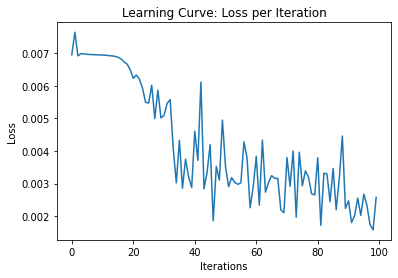

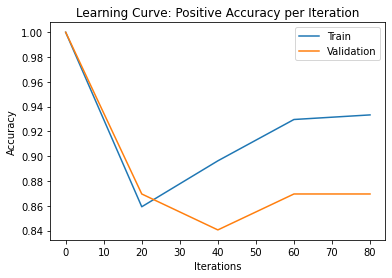

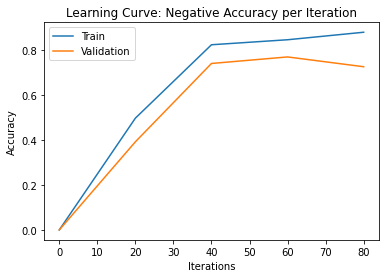

In [ ]:
# Include the training curves for the two models.
# Q.2(b)
best_learning_rate=0.001
best_n_channels=16
best_kernel_size=3
batch_size=100
model_CNNChannel = CNNChannel(best_n_channels,best_kernel_size)


# Train the model on the small subset of the data
iters, losses, iters_sub, train_pos_accs,train_neg_accs, val_pos_accs, val_neg_accs=train_model(model_CNNChannel, train_data, valid_data, learning_rate=0.001,batch_size=batch_size, num_epochs=100,print_number=20)


# Calculate the accuracy on the small subset of the data
pos_acc, neg_acc = get_accuracy(model_CNNChannel, train_data, batch_size=batch_size)
print(f"Training accuracy = {(pos_acc + neg_acc) / 2}")

plot_learning_curve(iters, losses, iters_sub, train_pos_accs,train_neg_accs, val_pos_accs, val_neg_accs)

Epoch 0: Training accuracy pos = 1.0 ,  Training accuracy neg =0.0, Training accuracy = 0.5 
Epoch 0: Validation accuracy pos = 1.0 ,  Validation accuracy neg =0.0, Validation accuracy = 0.5 
Epoch 10: Training accuracy pos = 0.044444444444444446 ,  Training accuracy neg =0.8703703703703703, Training accuracy = 0.4574074074074074 
Epoch 10: Validation accuracy pos = 0.014492753623188406 ,  Validation accuracy neg =0.927536231884058, Validation accuracy = 0.47101449275362317 
Epoch 20: Training accuracy pos = 0.5444444444444444 ,  Training accuracy neg =0.5148148148148148, Training accuracy = 0.5296296296296297 
Epoch 20: Validation accuracy pos = 0.5217391304347826 ,  Validation accuracy neg =0.4492753623188406, Validation accuracy = 0.4855072463768116 
Epoch 30: Training accuracy pos = 0.6444444444444445 ,  Training accuracy neg =0.6925925925925925, Training accuracy = 0.6685185185185185 
Epoch 30: Validation accuracy pos = 0.7536231884057971 ,  Validation accuracy neg =0.565217391304

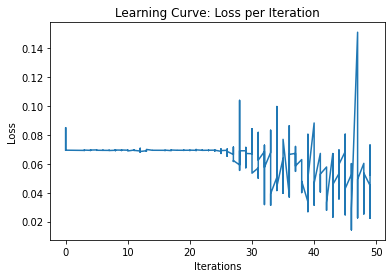

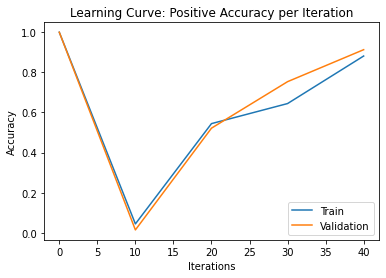

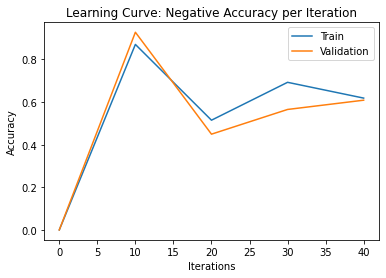

In [58]:
# Q.2(b)
best_learning_rate=0.0001
best_n_channels=32
best_kernel_size=3
batch_size=10
best_accuracy=0

model_CNN = CNN(best_n_channels,best_kernel_size)

# Train the model on the small subset of the data
iters, losses, iters_sub, train_pos_accs,train_neg_accs, val_pos_accs, val_neg_accs=train_model(model_CNN, train_data, valid_data, learning_rate=0.001,batch_size=batch_size, num_epochs=50)


# Calculate the accuracy on the small subset of the data
pos_acc, neg_acc = get_accuracy(model_CNN, train_data, batch_size=batch_size)
print(f"Training accuracy = {(pos_acc + neg_acc) / 2}")

plot_learning_curve(iters, losses, iters_sub, train_pos_accs,train_neg_accs, val_pos_accs, val_neg_accs)

## Question 4. Testing (15%)

### Part (a) -- 7%

Report the test accuracies of your **single best** model,
separately for the two test sets.
Do this by choosing the  model
architecture that produces the best validation accuracy. For instance,
if your model attained the
best validation accuracy in epoch 12, then the weights at epoch 12 is what you should be using
to report the test accuracy.

In [ ]:
# Write your code here. Make sure to include the test accuracy in your report
best_learning_rate=0.001
best_n_channels=16
best_kernel_size=3
batch_size=100
model_CNNChannel = CNNChannel(best_n_channels,best_kernel_size)
iters, losses, iters_sub, train_pos_accs,train_neg_accs, val_pos_accs, val_neg_accs,best_model=train_model(model_CNNChannel, train_data, valid_data, learning_rate=0.001,batch_size=batch_size, num_epochs=150,print_number=20,save_model=True)




Epoch 0: Training accuracy pos = 1.0 ,  Training accuracy neg =0.0, Training accuracy = 0.5 
Epoch 0: Validation accuracy pos = 1.0 ,  Validation accuracy neg =0.0, Validation accuracy = 0.5 
Epoch 20: Training accuracy pos = 0.8592592592592593 ,  Training accuracy neg =0.4962962962962963, Training accuracy = 0.6777777777777778 
Epoch 20: Validation accuracy pos = 0.8695652173913043 ,  Validation accuracy neg =0.391304347826087, Validation accuracy = 0.6304347826086957 
Epoch 40: Training accuracy pos = 0.8962962962962963 ,  Training accuracy neg =0.8222222222222222, Training accuracy = 0.8592592592592592 
Epoch 40: Validation accuracy pos = 0.8405797101449275 ,  Validation accuracy neg =0.7391304347826086, Validation accuracy = 0.7898550724637681 
Epoch 60: Training accuracy pos = 0.9296296296296296 ,  Training accuracy neg =0.8444444444444444, Training accuracy = 0.8870370370370371 
Epoch 60: Validation accuracy pos = 0.8695652173913043 ,  Validation accuracy neg =0.7681159420289855,

In [ ]:
test_m_pos, test_m_neg= get_accuracy(best_model, test_m)
test_w_pos, test_w_neg= get_accuracy(best_model, test_w)
print('CNN Channels Model Result:' )
print(f' test_m : accuracy pos - {test_m_pos} , accuracy neg - {test_m_neg} ,Test_m accuracy = {(test_m_pos + test_m_neg) / 2} ')
print(f' test_w : accuracy pos - {test_w_pos} , accuracy neg - {test_w_neg} ,Test_w accuracy = {(test_w_pos + test_w_neg) / 2} ')

CNN Channels Model Result:
 test_m : accuracy pos - 0.8 , accuracy neg - 0.7 ,Test_m accuracy = 0.75 
 test_w : accuracy pos - 0.8 , accuracy neg - 0.8 ,Test_w accuracy = 0.8 


### Part (b) -- 4%

Display one set of men's shoes that your model correctly classified as being
from the same pair.

If your test accuracy was not 100% on the men's shoes test set,
display one set of inputs that your model classified incorrectly.

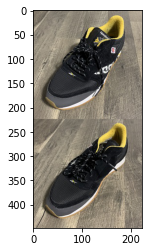

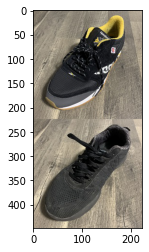

<Figure size 432x288 with 0 Axes>

In [ ]:
data_pos_m = np.array(generate_same_pair(test_m),dtype = float)
data_neg_m= np.array(generate_different_pair(test_m) , dtype=float)


for i in range(0, len(data_pos_m), 10):
    xs = torch.Tensor(data_pos_m[i:i+10]).transpose(1, 3).transpose(2,3)
    zs = best_model(xs)  
    pred = zs.max(1, keepdim=True)[1] # get the index of the max logit
    pred = pred.detach().numpy()
    
    for k in range(len(pred)):
        if(pred[k] == 1):
            img = ((data_pos_m[i + k])+0.5)*255
            img = np.array(img, dtype=int)
            plt.imshow(img)
            plt.figure()
            break
    break

for i in range(0, len(data_neg_m), 10):
    xs = torch.Tensor(data_neg_m[i:i+10]).transpose(1, 3).transpose(2,3)
    zs = best_model(xs)  
    pred = zs.max(1, keepdim=True)[1] # get the index of the max logit
    pred = pred.detach().numpy()
    
    for k in range(len(pred)):
        if(pred[k] == 1):
            img = ((data_neg_m[i + k])+0.5)*255
            img = np.array(img, dtype=int)
            plt.imshow(img)
            plt.figure()
            break
    break



### Part (c) -- 4%

Display one set of women's shoes that your model correctly classified as being
from the same pair.

If your test accuracy was not 100% on the women's shoes test set,
display one set of inputs that your model classified incorrectly.

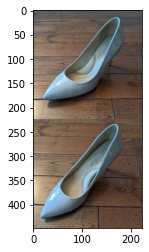

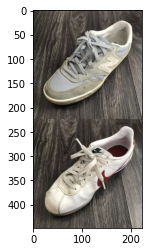

<Figure size 432x288 with 0 Axes>

In [ ]:
data_pos_w = np.array(generate_same_pair(test_w),dtype = float)
data_neg_w = np.array(generate_different_pair(test_w) , dtype=float)


for i in range(0, len(data_pos_w), 10):
    xs = torch.Tensor(data_pos_w[i:i+10]).transpose(1, 3).transpose(2,3)
    zs = best_model(xs)  
    pred = zs.max(1, keepdim=True)[1] # get the index of the max logit
    pred = pred.detach().numpy()
    
    for k in range(len(pred)):
        if(pred[k] == 1):
            img = ((data_pos_w[i + k])+0.5)*255
            img = np.array(img, dtype=int)
            plt.imshow(img)
            plt.figure()
            break
    break

for i in range(0, len(data_neg_w), 10):
    xs = torch.Tensor(data_neg_w[i:i+10]).transpose(1, 3).transpose(2,3)
    zs = best_model(xs)  
    pred = zs.max(1, keepdim=True)[1] # get the index of the max logit
    pred = pred.detach().numpy()
    
    for k in range(len(pred)):
        if(pred[k] == 1):
            img = ((data_neg_w[i + k])+0.5)*255
            img = np.array(img, dtype=int)
            plt.imshow(img)
            plt.figure()
            break
    break